# Notebook Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [3]:
# Import data
orig_df = pd.read_csv("cars.csv")
orig_df.head()

,Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin
0,STRING;DOUBLE;INT;DOUBLE;DOUBLE;DOUBLE;DOUBLE;...
1,Chevrolet Chevelle Malibu;18.0;8;307.0;130.0;3...
2,Buick Skylark 320;15.0;8;350.0;165.0;3693.;11....
3,Plymouth Satellite;18.0;8;318.0;150.0;3436.;11...
4,AMC Rebel SST;16.0;8;304.0;150.0;3433.;12.0;70;US


## Data Preparation

In [4]:
# Extract column names from the header string
columns = orig_df.columns[0].split(';')

# Split the single column into multiple columns and assign them proper headers
orig_df = orig_df[orig_df.columns[0]].str.split(';', expand=True)
orig_df.columns = columns

# Drop the first row which contains dtype information
orig_df = orig_df.iloc[1:]

display(orig_df.head())
print(orig_df.shape)

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
1,Chevrolet Chevelle Malibu,18.0,8,307.0,130.0,3504.,12.0,70,US
2,Buick Skylark 320,15.0,8,350.0,165.0,3693.,11.5,70,US
3,Plymouth Satellite,18.0,8,318.0,150.0,3436.,11.0,70,US
4,AMC Rebel SST,16.0,8,304.0,150.0,3433.,12.0,70,US
5,Ford Torino,17.0,8,302.0,140.0,3449.,10.5,70,US


(406, 9)


In [5]:
orig_df.dtypes

Car             object
MPG             object
Cylinders       object
Displacement    object
Horsepower      object
Weight          object
Acceleration    object
Model           object
Origin          object
dtype: object

In [6]:
# Re-assign column dtypes
orig_df['Car'] = orig_df['Car'].astype(str)
orig_df['MPG'] = orig_df['MPG'].astype(float)
orig_df['Cylinders'] = orig_df['Cylinders'].astype(int)
orig_df['Displacement'] = orig_df['Displacement'].astype(float)
orig_df['Horsepower'] = orig_df['Horsepower'].astype(float)
orig_df['Weight'] = orig_df['Weight'].astype(float)
orig_df['Acceleration'] = orig_df['Acceleration'].astype(float)
orig_df['Model'] = orig_df['Model'].astype(int)
orig_df['Origin'] = orig_df['Origin'].astype('category')

display(orig_df.dtypes)

Car               object
MPG              float64
Cylinders          int64
Displacement     float64
Horsepower       float64
Weight           float64
Acceleration     float64
Model              int64
Origin          category
dtype: object

In [7]:
# Check for missing values
orig_df.isnull().sum()

Car             0
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model           0
Origin          0
dtype: int64

In [8]:
# Check for duplicate rows
orig_df.duplicated().sum()

0

In [9]:
# Check for row & column consistency
column_consistency = len(orig_df.columns) == len(set(orig_df.columns))
row_consistency = all(orig_df.notnull().sum(axis=1) == len(columns))

print(f"Column Consistency: {column_consistency}")
print(f"Row Consistency: {row_consistency}")

Column Consistency: True
Row Consistency: True


## Exploratory Data Analysis

### Numerical Columns

In [10]:
# Summary statistics of the numerical columns
display(orig_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
MPG,406.0,23.051232,8.401777,0.0,17.0,22.35,29.000,46.6
Cylinders,406.0,5.475369,1.712160,3.0,4.0,4.00,8.000,8.0
Displacement,406.0,194.779557,104.922458,68.0,105.0,151.00,302.000,455.0
Horsepower,406.0,103.529557,40.520659,0.0,75.0,93.50,129.000,230.0
Weight,406.0,2979.413793,847.004328,1613.0,2226.5,2822.50,3618.250,5140.0
Acceleration,406.0,15.519704,2.803359,8.0,13.7,15.50,17.175,24.8
Model,406.0,75.921182,3.748737,70.0,73.0,76.00,79.000,82.0


What stands out in this summary is the mins for MPG & Horsepower - these 0's indicate missing data. This requires further exploration.

In [11]:
mpg_zero_rows = orig_df[orig_df['MPG'] == 0]
horsepower_zero_rows = orig_df[orig_df['Horsepower'] == 0]

print("MPG zero-value rows:")
display(mpg_zero_rows)
print("Horsepower zero-value rows:")
display(horsepower_zero_rows)

MPG zero-value rows:


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
11,Citroen DS-21 Pallas,0.0,4,133.0,115.0,3090.0,17.5,70,Europe
12,Chevrolet Chevelle Concours (sw),0.0,8,350.0,165.0,4142.0,11.5,70,US
13,Ford Torino (sw),0.0,8,351.0,153.0,4034.0,11.0,70,US
14,Plymouth Satellite (sw),0.0,8,383.0,175.0,4166.0,10.5,70,US
15,AMC Rebel SST (sw),0.0,8,360.0,175.0,3850.0,11.0,70,US
18,Ford Mustang Boss 302,0.0,8,302.0,140.0,3353.0,8.0,70,US
40,Volkswagen Super Beetle 117,0.0,4,97.0,48.0,1978.0,20.0,71,Europe
368,Saab 900s,0.0,4,121.0,110.0,2800.0,15.4,81,Europe


Horsepower zero-value rows:


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
39,Ford Pinto,25.0,4,98.0,0.0,2046.0,19.0,71,US
134,Ford Maverick,21.0,6,200.0,0.0,2875.0,17.0,74,US
338,Renault Lecar Deluxe,40.9,4,85.0,0.0,1835.0,17.3,80,Europe
344,Ford Mustang Cobra,23.6,4,140.0,0.0,2905.0,14.3,80,US
362,Renault 18i,34.5,4,100.0,0.0,2320.0,15.8,81,Europe
383,AMC Concord DL,23.0,4,151.0,0.0,3035.0,20.5,82,US


In [12]:
df = orig_df.copy()

In [13]:
# Find matching cars with non-zero values
non_zero_mpg = df[df['MPG'] != 0]
non_zero_hp = df[df['Horsepower'] != 0]

# Show which zero-value cars have matches
zero_mpg_cars_with_matches = mpg_zero_rows['Car'].isin(non_zero_mpg['Car'])
zero_hp_cars_with_matches = horsepower_zero_rows['Car'].isin(non_zero_hp['Car'])

print("MPG zero-value cars with matches:")
print(mpg_zero_rows[zero_mpg_cars_with_matches]['Car'])
print("\nHorsepower zero-value cars with matches:")
print(horsepower_zero_rows[zero_hp_cars_with_matches]['Car'])

MPG zero-value cars with matches:
12    Chevrolet Chevelle Concours (sw)
Name: Car, dtype: object

Horsepower zero-value cars with matches:
39        Ford Pinto
134    Ford Maverick
Name: Car, dtype: object


In [14]:
# Replace MPG for Chevrolet Chevelle Concours (sw)
matching_mpg = df[(df['Car'] == 'Chevrolet Chevelle Concours (sw)') & (df['MPG'] != 0)]['MPG'].iloc[0]
df.loc[df['Car'] == 'Chevrolet Chevelle Concours (sw)', 'MPG'] = matching_mpg

# Replace Horsepower for Ford Pinto and Ford Maverick
for car in ['Ford Pinto', 'Ford Maverick']:
    matching_hp = df[(df['Car'] == car) & (df['Horsepower'] != 0)]['Horsepower'].iloc[0]
    df.loc[df['Car'] == car, 'Horsepower'] = matching_hp

In [15]:
# Run the check again
mpg_zero_rows = df[df['MPG'] == 0]
horsepower_zero_rows = df[df['Horsepower'] == 0]

print("MPG zero-value rows:")
display(mpg_zero_rows)
print("Horsepower zero-value rows:")
display(horsepower_zero_rows)

MPG zero-value rows:


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
11,Citroen DS-21 Pallas,0.0,4,133.0,115.0,3090.0,17.5,70,Europe
13,Ford Torino (sw),0.0,8,351.0,153.0,4034.0,11.0,70,US
14,Plymouth Satellite (sw),0.0,8,383.0,175.0,4166.0,10.5,70,US
15,AMC Rebel SST (sw),0.0,8,360.0,175.0,3850.0,11.0,70,US
18,Ford Mustang Boss 302,0.0,8,302.0,140.0,3353.0,8.0,70,US
40,Volkswagen Super Beetle 117,0.0,4,97.0,48.0,1978.0,20.0,71,Europe
368,Saab 900s,0.0,4,121.0,110.0,2800.0,15.4,81,Europe


Horsepower zero-value rows:


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
338,Renault Lecar Deluxe,40.9,4,85.0,0.0,1835.0,17.3,80,Europe
344,Ford Mustang Cobra,23.6,4,140.0,0.0,2905.0,14.3,80,US
362,Renault 18i,34.5,4,100.0,0.0,2320.0,15.8,81,Europe
383,AMC Concord DL,23.0,4,151.0,0.0,3035.0,20.5,82,US


In [16]:
# Drop rows where MPG or Horsepower is still 0
df = df[(df['MPG'] != 0) & (df['Horsepower'] != 0)]

In [17]:
# Run the check the last time
mpg_zero_rows = df[df['MPG'] == 0]
horsepower_zero_rows = df[df['Horsepower'] == 0]

print("MPG zero-value rows:")
display(mpg_zero_rows)
print("Horsepower zero-value rows:")
display(horsepower_zero_rows)
print("Dataset shape:", df.shape)

MPG zero-value rows:


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin


Horsepower zero-value rows:


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin


Dataset shape: (395, 9)


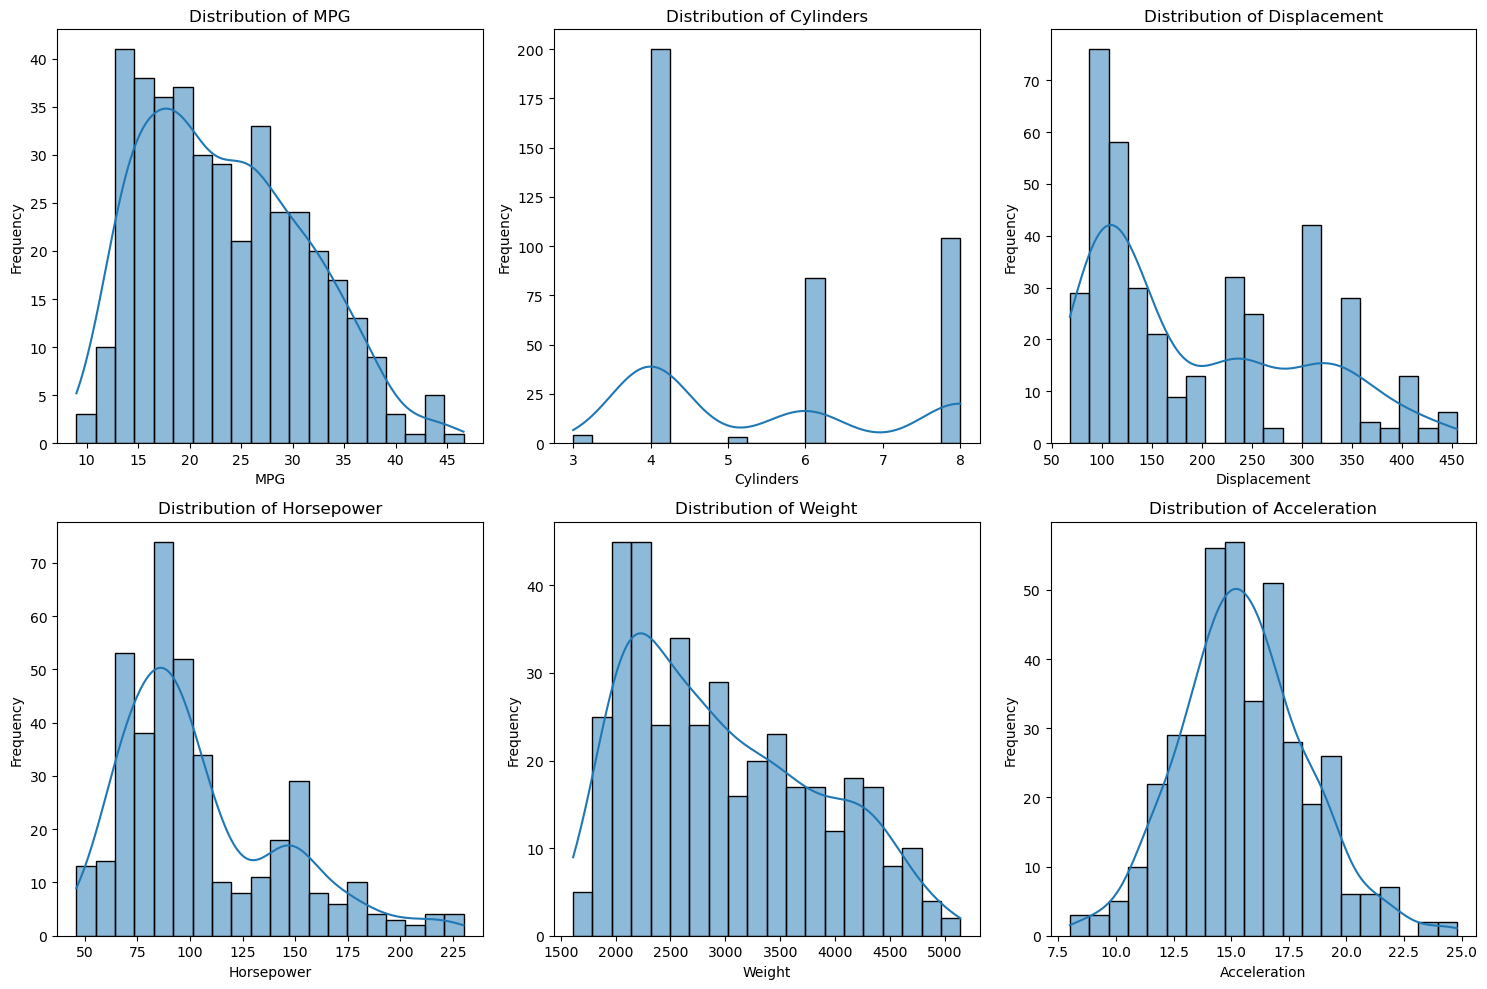

In [18]:
# Get numerical columns (excluding 'Model')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('Model')

# Create histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
   plt.subplot(2, 3, i)
   sns.histplot(data=df, x=col, bins=20, kde=True, edgecolor='black')
   plt.title(f'Distribution of {col}')
   plt.xlabel(col)
   plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

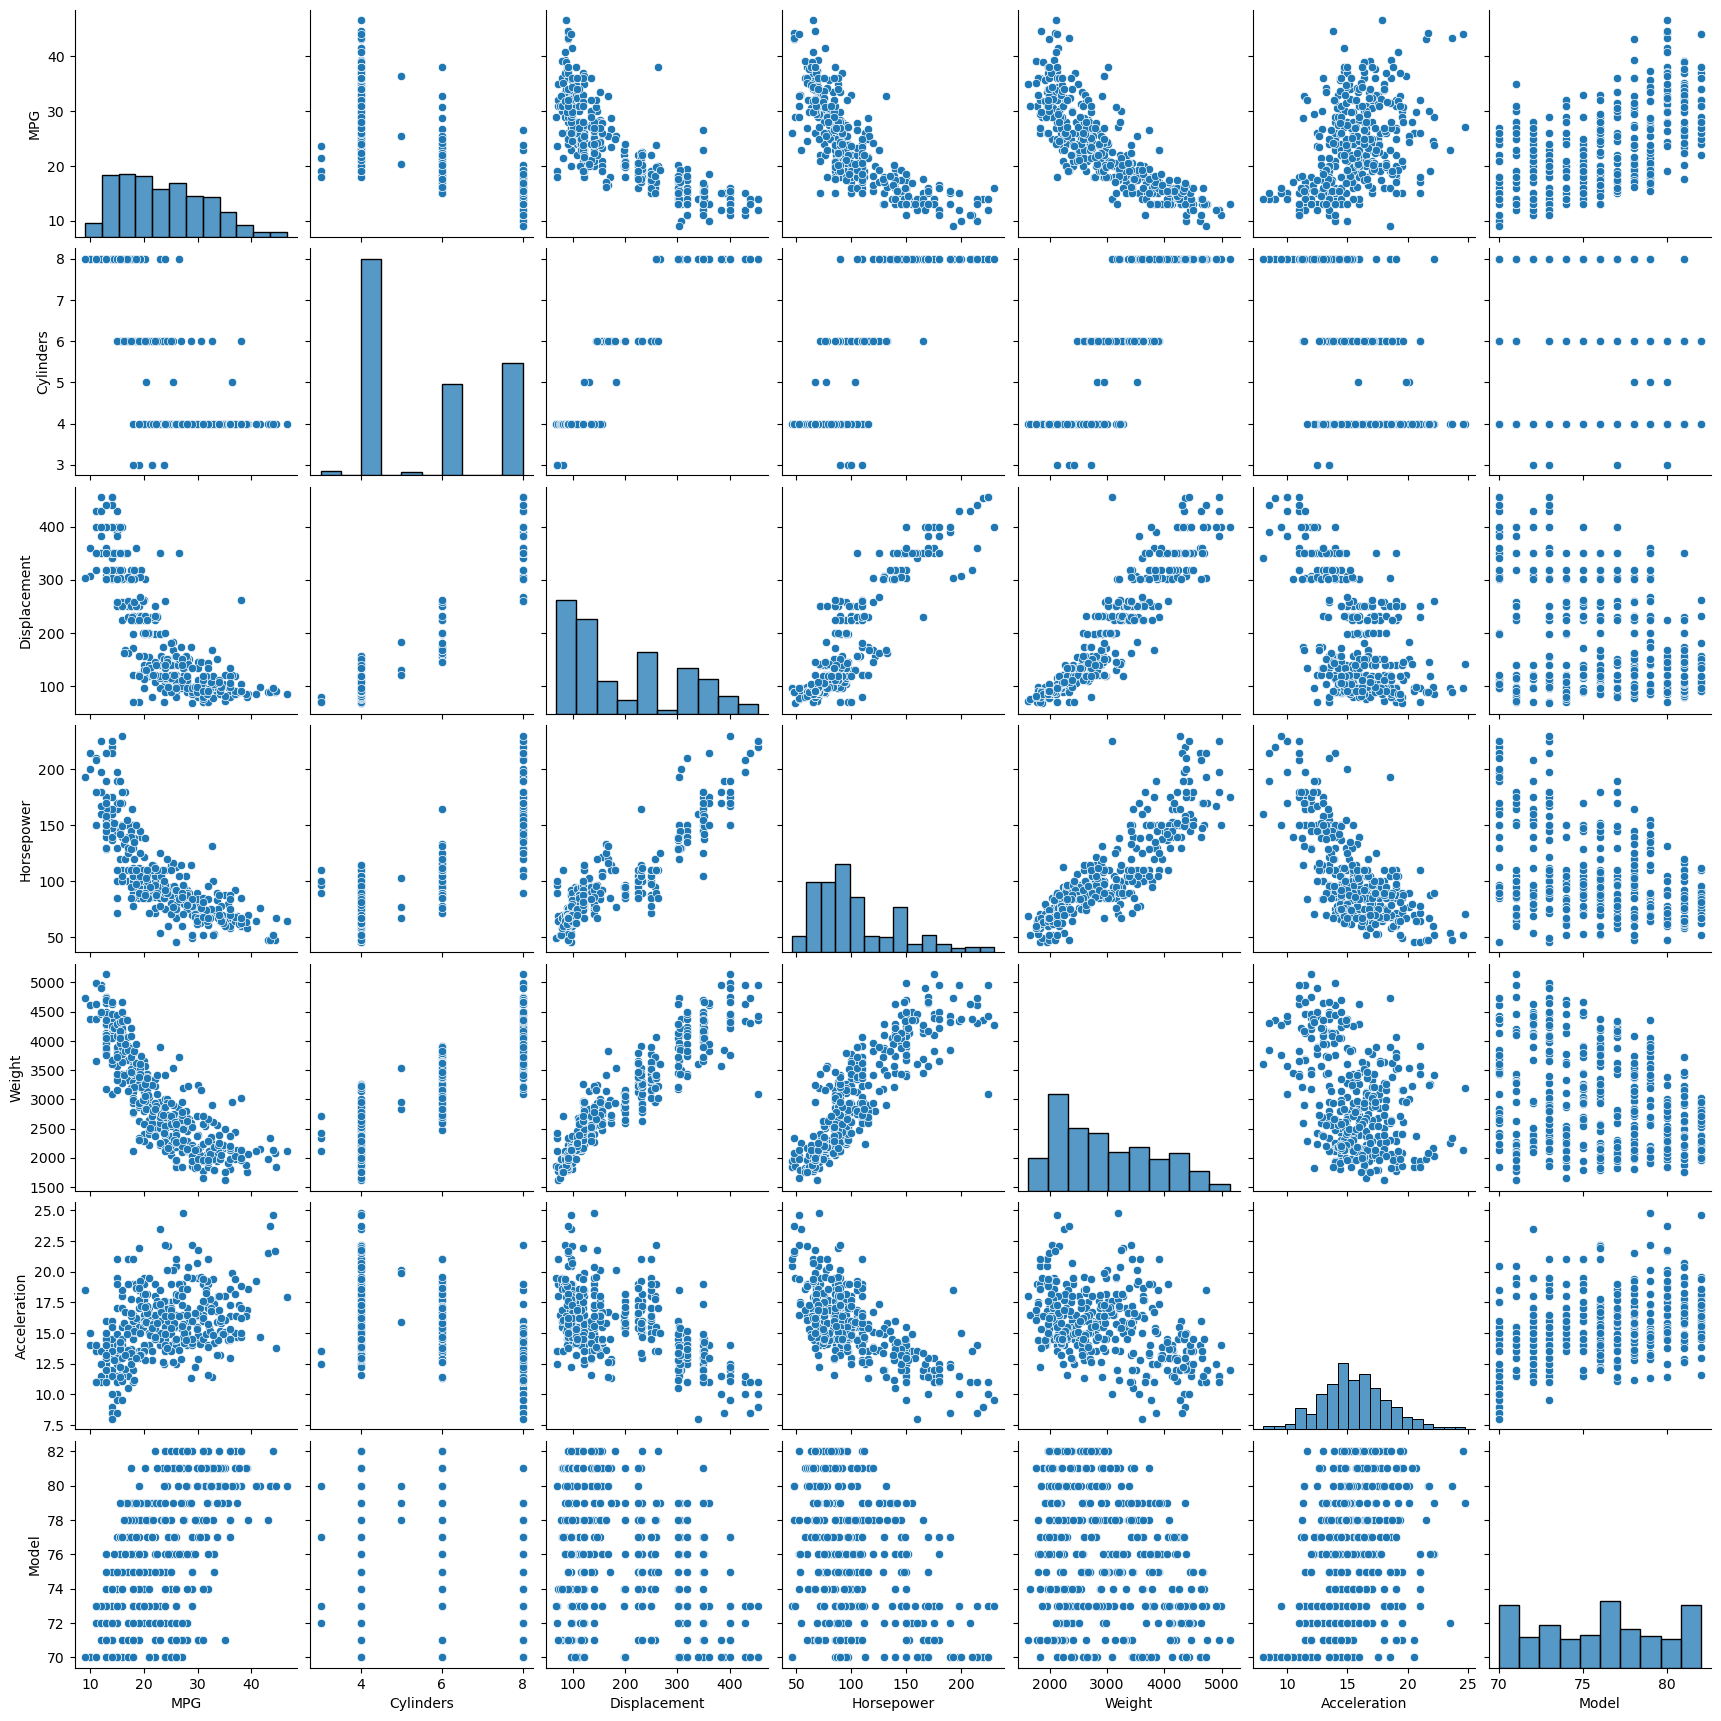

In [19]:
# Explore pairwise relationships of the numerical columns
sns.pairplot(df)
plt.show()

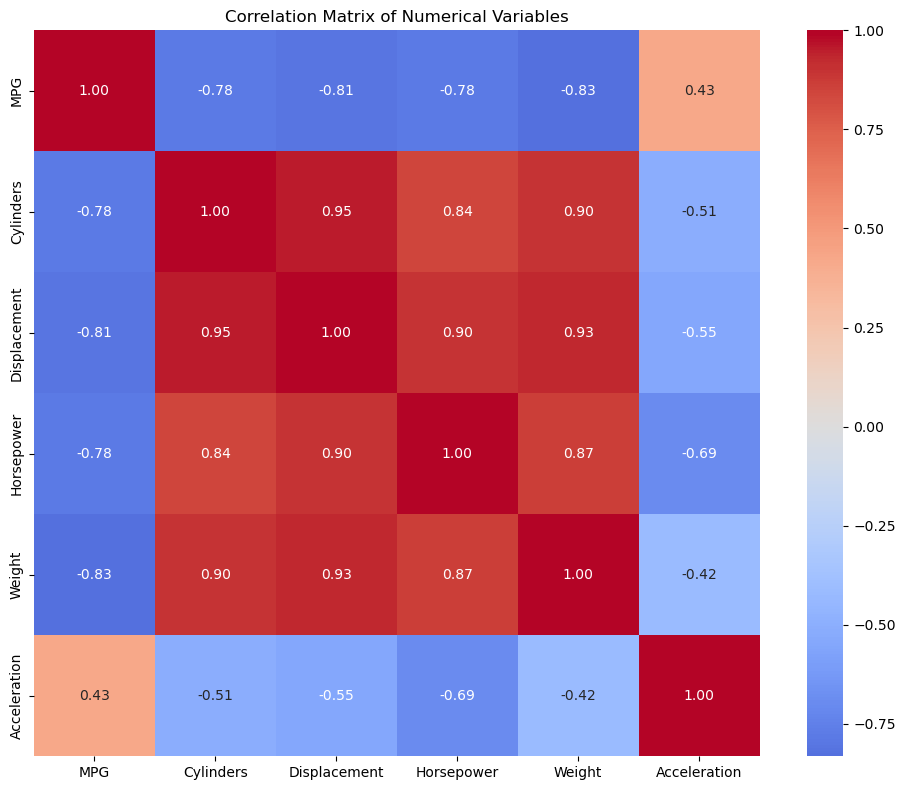

In [20]:
# Create a correlation matrix
plt.figure(figsize=(10, 8))
correlation = df[num_cols].corr()

# Create heatmap
sns.heatmap(correlation, 
           annot=True,  # Show correlation values
           cmap='coolwarm',  # Color scheme
           center=0,  # Center the colormap at 0
           fmt='.2f',  # Round to 2 decimal places
           square=True)  # Make cells square

plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

### Interpretation of analysis of numerical variables

1. I found rows with zero values for MPG & Horsepower, which is indicative of missing data. After attempting to replace the zero values by matching on car name, I have dropped the rows with a zero in either column. The intent is to avoid feeding bad data to any model that will be trained later in this notebook. Given more time & access to external data, I could attempt to replace the missing data instead of dropping the rows.

2. The histograms of the predictor variables show significant skew. This could be corrected by using transformations such as taking logs or square roots. Since I'm working with limited time, I will use regression methods that do not assume normality, such as tree-based methods.

3. The pairplot of MPG with the predictor variables shows non-linear relationships. This will require corrections, which would once again suggest the use of a polynomial analysis. However, since time is limited, I will test boosting models.

4. High correlation between displacement, horsepower & weight suggests the use of feature engineering or PCA to handle the expected multicollinearity.

### Non-numerical Columns

In [21]:
# Get non-numerical columns
non_num_cols = df.select_dtypes(exclude=['float64', 'int64']).columns

# Display value counts for each non-numerical column
for col in non_num_cols:
   print(f"\nDistribution of {col}:")
   print(df[col].value_counts())
   print(f"Number of unique values: {df[col].nunique()}")


Distribution of Car:
Car
Toyota Corolla                9
Ford Pinto                    6
AMC Matador                   5
Ford Maverick                 5
Volkswagen Rabbit             5
                             ..
Chevrolete Chevelle Malibu    1
Plymouth Fury                 1
Buick Skyhawk                 1
Chevrolet Monza 2+2           1
Chevy S-10                    1
Name: count, Length: 297, dtype: int64
Number of unique values: 297

Distribution of Origin:
Origin
US        248
Japan      79
Europe     68
Name: count, dtype: int64
Number of unique values: 3


Cylinders & origin have few enough unique values to be usable in the analysis. However, the number of unique values in Cars is very high relative to the total number of rows (297 out of 395). It also appears that car makes are not uniformly identified (e.g. Chevrolet Monza 2+2 & Chevy S-10, which both refer to the same make). I will extract the car make and correct the differences. 

In [22]:
# Create Make column from first word of Car
df['Make'] = df['Car'].str.split().str[0].astype('category')

# Display the counts
print("Distribution of Make:")
print(df['Make'].value_counts().sort_index())

Distribution of Make:
Make
AMC              27
Audi              7
BMW               2
Buick            17
Cadillac          2
Capri             1
Chevrolet        45
Chevrolete        1
Chevy             2
Chrysler          6
Datsun           23
Dodge            28
Fiat              8
Ford             50
Hi                1
Honda            13
Mazda            12
Mercedes          1
Mercedes-Benz     2
Mercury          11
Nissan            1
Oldsmobile       10
Opel              4
Peugeot           8
Plymouth         31
Pontiac          16
Renault           3
Saab              4
Subaru            4
Toyota           26
Triumph           1
Volkswagen       22
Volvo             6
Name: count, dtype: int64


In [23]:
# Create dictionary for name standardization
make_mapping = {
   'Chevrolete': 'Chevrolet',
   'Chevy': 'Chevrolet',
   'Mercedes': 'Mercedes-Benz'
}

# Create 'Make' column and standardize names
df['Make'] = df['Car'].str.split().str[0]
df['Make'] = df['Make'].replace(make_mapping).astype('category')

# Display sorted unique values and their counts
print(df['Make'].value_counts().sort_index())

Make
AMC              27
Audi              7
BMW               2
Buick            17
Cadillac          2
Capri             1
Chevrolet        48
Chrysler          6
Datsun           23
Dodge            28
Fiat              8
Ford             50
Hi                1
Honda            13
Mazda            12
Mercedes-Benz     3
Mercury          11
Nissan            1
Oldsmobile       10
Opel              4
Peugeot           8
Plymouth         31
Pontiac          16
Renault           3
Saab              4
Subaru            4
Toyota           26
Triumph           1
Volkswagen       22
Volvo             6
Name: count, dtype: int64


This still leaves too many categories to be able to use this column in analysis, so I will group makes with less than 10 cars into a single category.

In [24]:
# Get makes with fewer than 10 cars
make_counts = df['Make'].value_counts()
rare_makes = make_counts[make_counts < 10].index

# Replace rare makes with 'Other'
df['Make'] = df['Make'].replace(rare_makes, 'Other')

# Display the new distribution
print(df['Make'].value_counts().sort_index())
print(f"\nTotal number of unique manufacturers: {df['Make'].nunique()}")

Make
AMC           27
Other         61
Buick         17
Chevrolet     48
Datsun        23
Dodge         28
Ford          50
Honda         13
Mazda         12
Mercury       11
Oldsmobile    10
Plymouth      31
Pontiac       16
Toyota        26
Volkswagen    22
Name: count, dtype: int64

Total number of unique manufacturers: 15


/var/folders/ty/f5d3n0vj42jdwf7h9rrgs5gh0000gn/T/ipykernel_14662/464925350.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Make'] = df['Make'].replace(rare_makes, 'Other')


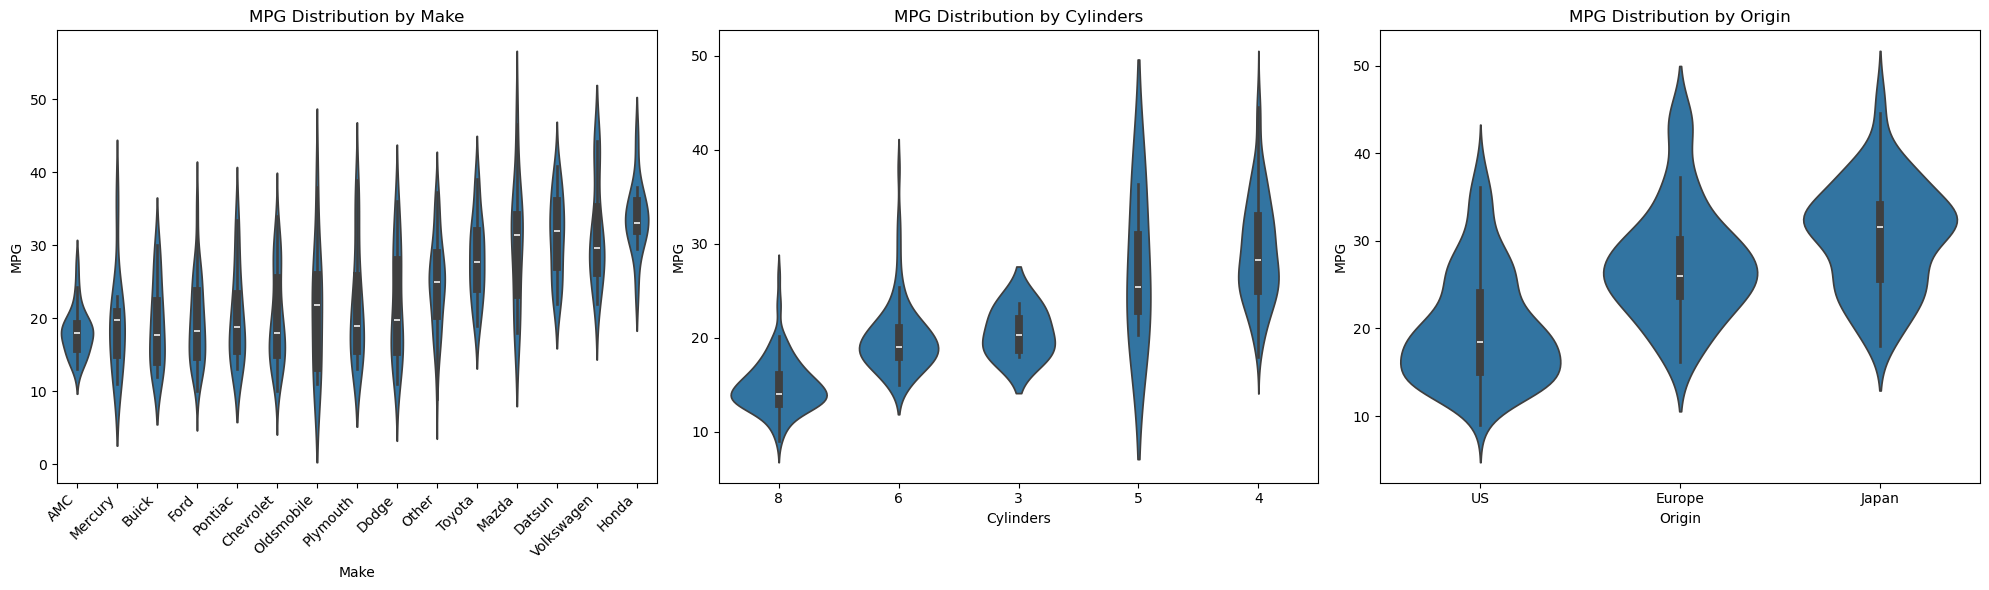

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# For Make
make_order = df.groupby('Make', observed=True)['MPG'].mean().sort_values().index
sns.violinplot(data=df, x='Make', y='MPG', ax=ax1, order=make_order)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.set_title('MPG Distribution by Make')

# For Cylinders
cyl_order = df.groupby('Cylinders', observed=True)['MPG'].mean().sort_values().index
sns.violinplot(data=df, x='Cylinders', y='MPG', ax=ax2, order=cyl_order)
ax2.set_title('MPG Distribution by Cylinders')

# For Origin
origin_order = df.groupby('Origin', observed=True)['MPG'].mean().sort_values().index
sns.violinplot(data=df, x='Origin', y='MPG', ax=ax3, order=origin_order)
ax3.set_title('MPG Distribution by Origin')

plt.tight_layout()
plt.show()

### Interpretation of analysis of non-numerical features

The violin plots show a non-linear relationship between these predictors and fuel efficiency and there is justification for inclusion of these variables in the models. 

For cylinders and origin, there appear to be clear differences in the fuel efficiency of cars with different values in these categories. The MPG values also seem to be concentrated around the mode. Hence using these two variables seems justified. I will be using OHE for Origin and Label Encoding for Cylinders, reflecting an absence & presence of natural order between values, respectively.

However, Make shows the opposite pattern - the means are very similar across categories and the values are very widely spread out within each category. It is likely that make will have very little impact on any predictive model, hence for computational efficiency, I will leave it out. However, I will be including a luxury maker variable that may carry some predictive value.

## Feature Engineering

Based on domain research, I will be adding the following variables:

1. Power Density - Horsepower / Displacement
2. Power to Weight Ratio - Horsepower / Weight
3. Model Age - this is the difference between the model year of the newest car and each car in the dataset
4. High horsepower - Above 75th percentile for horsepower, which reduces fuel efficiency
5. Light weight - Below 25th percentile for weight, which have high fuel efficiency
6. Fast acceleration - Below 25th percentile in acceleration time, which have the least fuel efficiency
7. Luxury Flag - Luxury car makers are not designing for fuel efficiency

In [26]:
# Power Density
df['Power_Density'] = df['Horsepower'] / df['Displacement']

# Power-to-weight ratio
df['Power_to_Weight'] = df['Horsepower'] / df['Weight']

# Model Age
newest_year = df['Model'].max()
df['Age'] = (newest_year - df['Model']).astype(int)

# Performance flags
hp_threshold = df['Horsepower'].quantile(0.75)
weight_threshold = df['Weight'].quantile(0.25)
accel_threshold = df['Acceleration'].quantile(0.25)

df['Is_High_Power'] = (df['Horsepower'] > hp_threshold).astype(int)
df['Is_Lightweight'] = (df['Weight'] < weight_threshold).astype(int)
df['Is_Fast_Acceleration'] = (df['Acceleration'] < accel_threshold).astype(int)

# Luxury maker flag
luxury_makers = ['Mercedes-Benz', 'BMW', 'Cadillac', 'Audi']
df['Is_Luxury'] = df['Car'].apply(lambda x: any(maker in x for maker in luxury_makers)).astype(int)

## Data Pre-Processing

In [27]:
# Encoding for non-numerical variables
df_encoded = pd.get_dummies(df, columns=['Origin'], prefix=['Origin'])
le = LabelEncoder()
df_encoded['Cylinders'] = le.fit_transform(df_encoded['Cylinders'])

In [28]:
# Drop Car & Model columns, then create X and y
X = df_encoded.drop(['Car', 'MPG', 'Model', 'Make'], axis=1)
y = df_encoded['MPG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Scale the features for training and test sets
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Question 1

Find the car with the highest MPG.

In [30]:
highest_mpg_car = orig_df.nlargest(1, "MPG").iloc[0]
print(f"The car with the highest MPG is the {highest_mpg_car['Car']}, with an MPG of {highest_mpg_car['MPG']}.")

The car with the highest MPG is the Mazda GLC, with an MPG of 46.6.


# Question 2

Find average MPG per cylinder count

In [31]:
avg_mpg_by_cylinders = orig_df.groupby("Cylinders")["MPG"].mean()
print("Average MPG by number of cylinders:")
for cylinders, mpg in avg_mpg_by_cylinders.items():
    print(f"{cylinders} cylinders: {mpg:.1f} MPG")

Average MPG by number of cylinders:
3 cylinders: 20.6 MPG
4 cylinders: 28.9 MPG
5 cylinders: 27.4 MPG
6 cylinders: 20.0 MPG
8 cylinders: 14.3 MPG


# Question 3

Find each make's average MPG (Chevy, Ford, etc)

In [32]:
orig_df['Make'] = orig_df['Car'].str.split().str[0].astype('category')
avg_mpg_by_make = orig_df.groupby('Make', observed=True)['MPG'].mean().sort_values(ascending=False)
print("Average MPG by make:")
for make, mpg in avg_mpg_by_make.items():
    print(f"{make}: {mpg:.1f} MPG")

Average MPG by make:
Nissan: 36.0 MPG
Triumph: 35.0 MPG
Honda: 33.8 MPG
Renault: 32.9 MPG
Datsun: 31.1 MPG
Subaru: 30.5 MPG
Volkswagen: 30.5 MPG
Mazda: 30.1 MPG
Fiat: 28.9 MPG
Toyota: 28.2 MPG
Audi: 26.7 MPG
Opel: 25.8 MPG
Mercedes: 25.4 MPG
Capri: 25.0 MPG
BMW: 23.8 MPG
Peugeot: 23.7 MPG
Mercedes-Benz: 23.2 MPG
Dodge: 22.1 MPG
Volvo: 21.1 MPG
Oldsmobile: 21.1 MPG
Plymouth: 21.0 MPG
Chevy: 20.5 MPG
Pontiac: 20.0 MPG
Chevrolet: 19.9 MPG
Cadillac: 19.8 MPG
Buick: 19.2 MPG
Saab: 19.1 MPG
Mercury: 19.1 MPG
Ford: 19.0 MPG
AMC: 17.6 MPG
Chrysler: 17.3 MPG
Chevrolete: 16.0 MPG
Hi: 9.0 MPG
Citroen: 0.0 MPG


The answer above uses the original dataset, which does not correct for missing MPG data or standardize the make names. The answer with these corrections made is given below.

In [33]:
df['Make'] = df['Car'].str.split().str[0].astype('category')
avg_mpg_by_make = df.groupby('Make', observed=True)['MPG'].mean().sort_values(ascending=False)
print("Average MPG by make:")
for make, mpg in avg_mpg_by_make.items():
    print(f"{make}: {mpg:.1f} MPG")

Average MPG by make:
Nissan: 36.0 MPG
Triumph: 35.0 MPG
Honda: 33.8 MPG
Volkswagen: 31.8 MPG
Datsun: 31.1 MPG
Subaru: 30.5 MPG
Mazda: 30.1 MPG
Renault: 29.7 MPG
Fiat: 28.9 MPG
Toyota: 28.2 MPG
Audi: 26.7 MPG
Opel: 25.8 MPG
Mercedes: 25.4 MPG
Capri: 25.0 MPG
Saab: 23.9 MPG
BMW: 23.8 MPG
Peugeot: 23.7 MPG
Mercedes-Benz: 23.2 MPG
Dodge: 22.1 MPG
Plymouth: 21.7 MPG
Volvo: 21.1 MPG
Oldsmobile: 21.1 MPG
Chevy: 20.5 MPG
Chevrolet: 20.1 MPG
Pontiac: 20.0 MPG
Cadillac: 19.8 MPG
Ford: 19.6 MPG
Buick: 19.2 MPG
Mercury: 19.1 MPG
AMC: 18.1 MPG
Chrysler: 17.3 MPG
Chevrolete: 16.0 MPG
Hi: 9.0 MPG


# Question 4

Build a predictive model to predict the MPG based on other data. What is your optimal error metric on the test set?

I will be testing a number of models:
- Multiple linear regression to serve as a baseline
- Lasso regression, since I have created a large number of variables and want to trim the number down
- Decision Tree Regressor, since the predictors are not normally distributed
- Random Forest Regressor
- XGBoost & LightGBM

To decide between the models, I will use three error metrics:
- RMSE, as the primary metric - it has the same unit as MPG which makes it very interpretable
- R² to detect overfitting
- Adjusted R² to penalize excess features

First, I will create a dataframe to store the results from each model & a function to write results to this df.

In [34]:
model_results = pd.DataFrame(columns=['Model', 'Train_RMSE', 'Train_R2', 'Train_Adj_R2', 
                                    'Test_RMSE', 'Test_R2', 'Test_Adj_R2', 'Test Sample Size', 'Number of Features'])

def evaluate_model(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred, n, p):
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_adj_r2 = 1 - (1 - train_r2) * (n - 1) / (n - p - 1)
    
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    test_r2 = r2_score(y_test_true, y_test_pred)
    test_adj_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Train_RMSE': [train_rmse],
        'Train_R2': [train_r2],
        'Train_Adj_R2': [train_adj_r2],
        'Test_RMSE': [test_rmse],
        'Test_R2': [test_r2],
        'Test_Adj_R2': [test_adj_r2],
        'Test Sample Size': [n],
        'Number of Features': [p]
    }, dtype=object)
    
    global model_results
    model_results = pd.concat([model_results, new_row], ignore_index=True)

The first model serves as the baseline - a multiple linear regression that uses all the features

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)
evaluate_model('Linear Regression', y_train, y_train_pred_lr, y_test, y_test_pred_lr, len(X_test), X_test.shape[1])

The next model is a Lasso regression, to trim the number of features down and find the most important ones

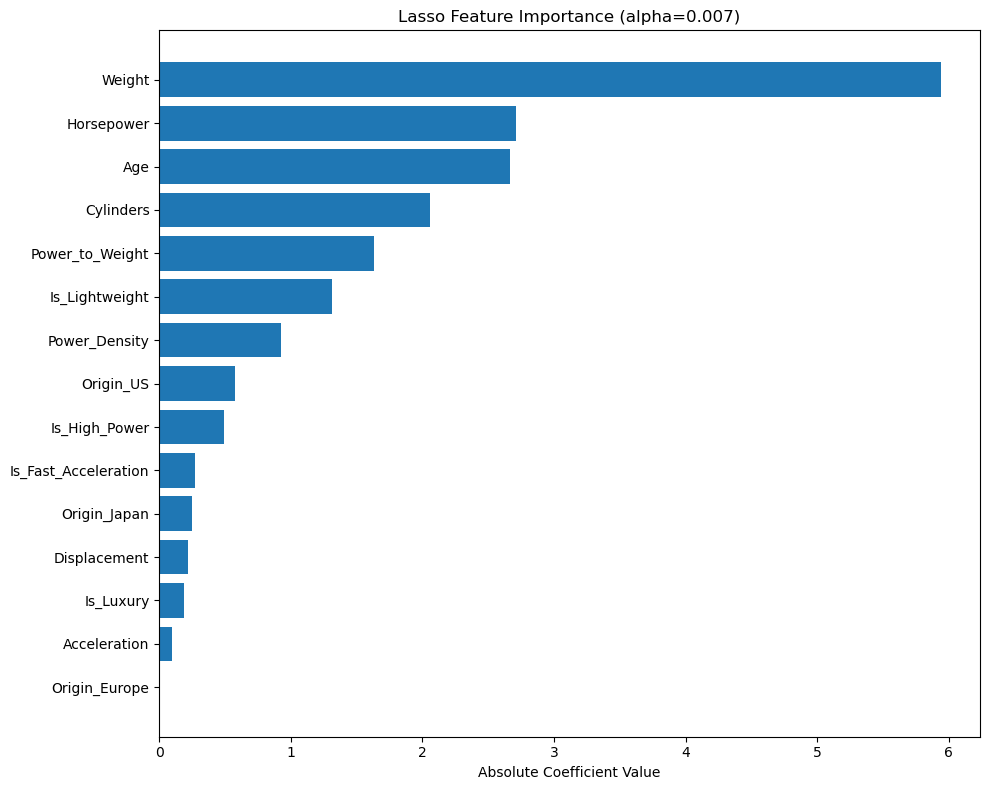

In [36]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)
y_train_pred_lasso = lasso_cv.predict(X_train)
y_test_pred_lasso = lasso_cv.predict(X_test)
evaluate_model('Lasso Regression', y_train, y_train_pred_lasso, y_test, y_test_pred_lasso, len(X_test), X_test.shape[1])

# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(lasso_cv.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title(f'Lasso Feature Importance (alpha={lasso_cv.alpha_:.3f})')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

Next comes a Decision Tree Regressor

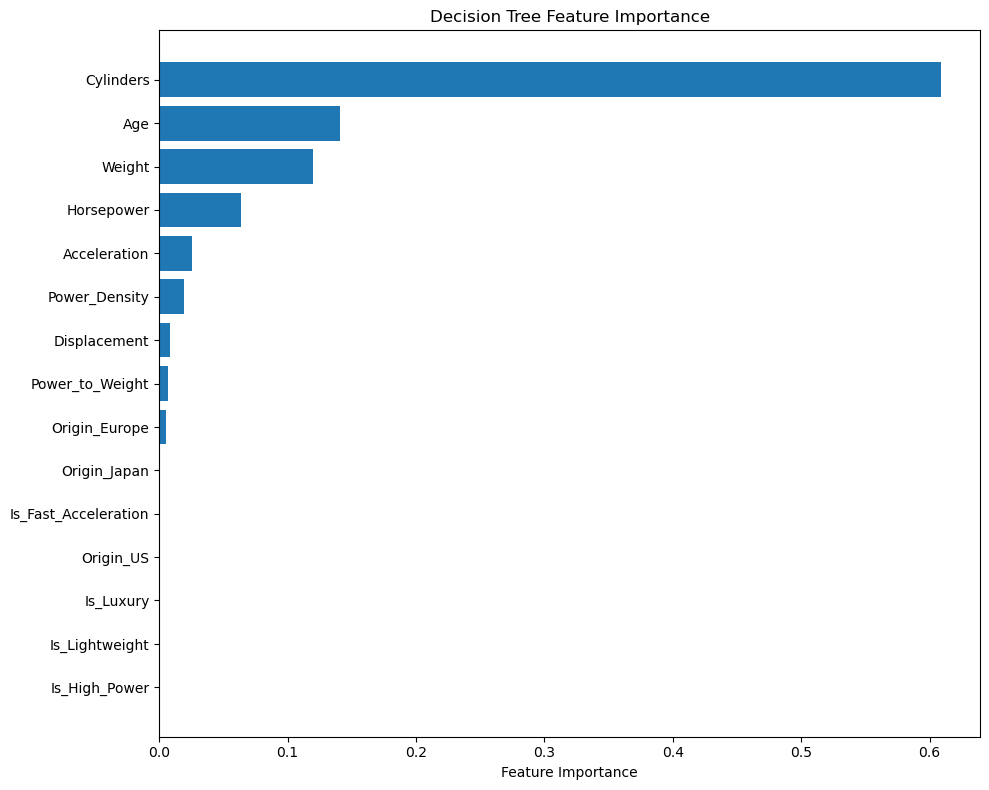

In [37]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)
evaluate_model('Decision Tree', y_train, y_train_pred_dt, y_test, y_test_pred_dt, len(X_test), X_test.shape[1])


# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Decision Tree Feature Importance')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

Next comes a Random Forest Regressor

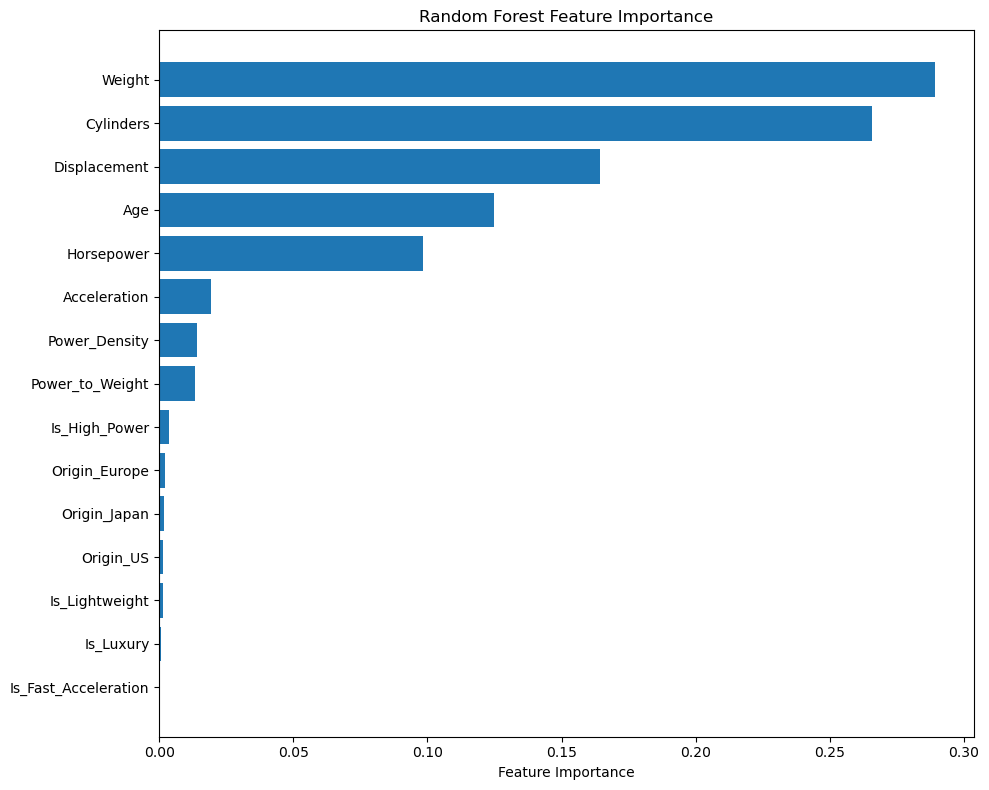

In [38]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)
evaluate_model('Random Forest', y_train, y_train_pred_rf, y_test, y_test_pred_rf, len(X_test), X_test.shape[1])


# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

I move on to an XGBoost Model

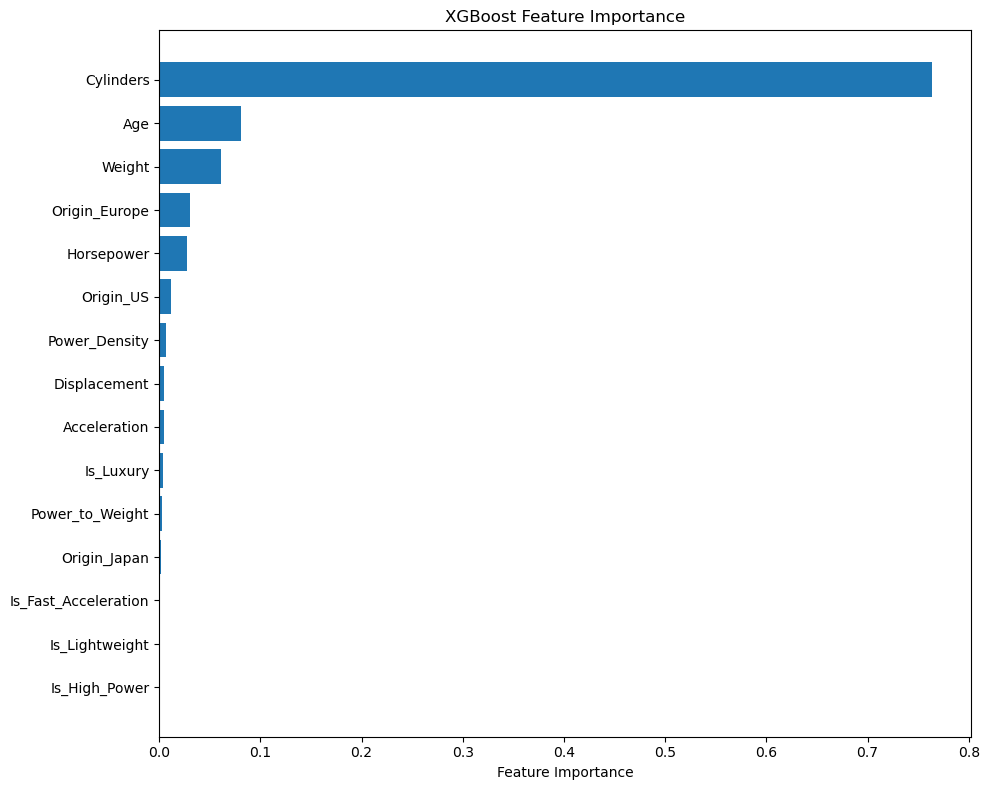

In [39]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)
evaluate_model('XGBoost', y_train, y_train_pred_xgb, y_test, y_test_pred_xgb, len(X_test), X_test.shape[1])

# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

And finally a LightGBM model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 14
[LightGBM] [Info] Start training from score 23.548101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

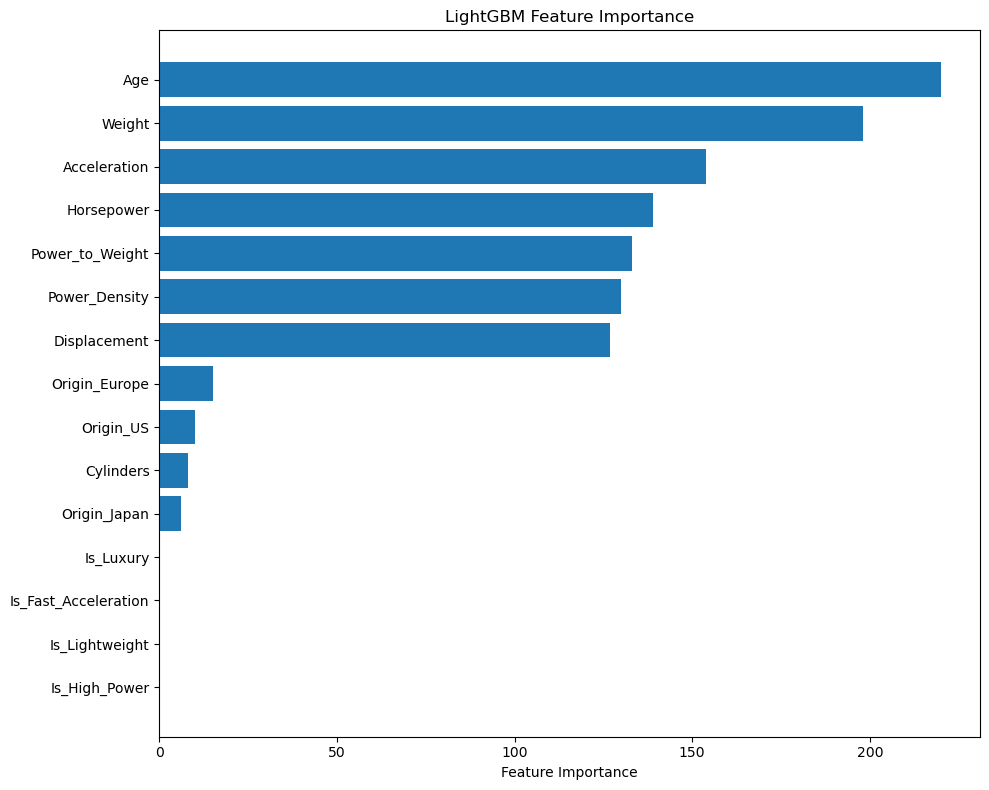

In [40]:
lgb = LGBMRegressor(random_state=42)
lgb.fit(X_train, y_train)
y_train_pred_lgb = lgb.predict(X_train)
y_test_pred_lgb = lgb.predict(X_test)
evaluate_model('LightGBM', y_train, y_train_pred_lgb, y_test, y_test_pred_lgb, len(X_test), X_test.shape[1])

# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('LightGBM Feature Importance')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [46]:
print(model_results.sort_values('Test_R2', ascending=False).to_string(index=False))

            Model Train_RMSE  Train_R2 Train_Adj_R2 Test_RMSE   Test_R2 Test_Adj_R2 Test Sample Size Number of Features
          XGBoost   0.013001  0.999997     0.999997  3.218265  0.827736    0.786721               79                 15
    Random Forest   0.953093  0.985018     0.981451   3.23643  0.825786    0.784306               79                 15
         LightGBM   1.209183  0.975885     0.970143  3.439163  0.803276    0.756437               79                 15
 Lasso Regression    2.76392  0.874004     0.844004  3.538862  0.791705    0.742111               79                 15
Linear Regression   2.759861  0.874373     0.844462  3.561757  0.789001    0.738764               79                 15
    Decision Tree        0.0       1.0          1.0  4.911985  0.598704    0.503157               79                 15


In [43]:
# Create importance tables for each model (top 5 features)
lasso_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': abs(lasso_cv.coef_)}) \
    .nlargest(5, 'Importance')['Feature'].tolist()

dt_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': dt.feature_importances_}) \
    .nlargest(5, 'Importance')['Feature'].tolist()

rf_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_}) \
    .nlargest(5, 'Importance')['Feature'].tolist()

xgb_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_}) \
    .nlargest(5, 'Importance')['Feature'].tolist()

lgb_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgb.feature_importances_}) \
    .nlargest(5, 'Importance')['Feature'].tolist()

comparison = pd.DataFrame({
    'Model': ['Lasso', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Top 5 Important Features': [
        ', '.join(lasso_imp),
        ', '.join(dt_imp),
        ', '.join(rf_imp),
        ', '.join(xgb_imp),
        ', '.join(lgb_imp)
    ]
})

print(comparison.to_string(index=False))

        Model                               Top 5 Important Features
        Lasso    Weight, Horsepower, Age, Cylinders, Power_to_Weight
Decision Tree       Cylinders, Age, Weight, Horsepower, Acceleration
Random Forest       Weight, Cylinders, Displacement, Age, Horsepower
      XGBoost      Cylinders, Age, Weight, Origin_Europe, Horsepower
     LightGBM Age, Weight, Acceleration, Horsepower, Power_to_Weight


In [44]:
# Combine and get unique features
all_important_features = list(set(lasso_imp + dt_imp + rf_imp + xgb_imp + lgb_imp))
print("Important features:", all_important_features)

Important features: ['Cylinders', 'Horsepower', 'Acceleration', 'Power_to_Weight', 'Age', 'Displacement', 'Weight', 'Origin_Europe']


#### Error Distribution Analysis

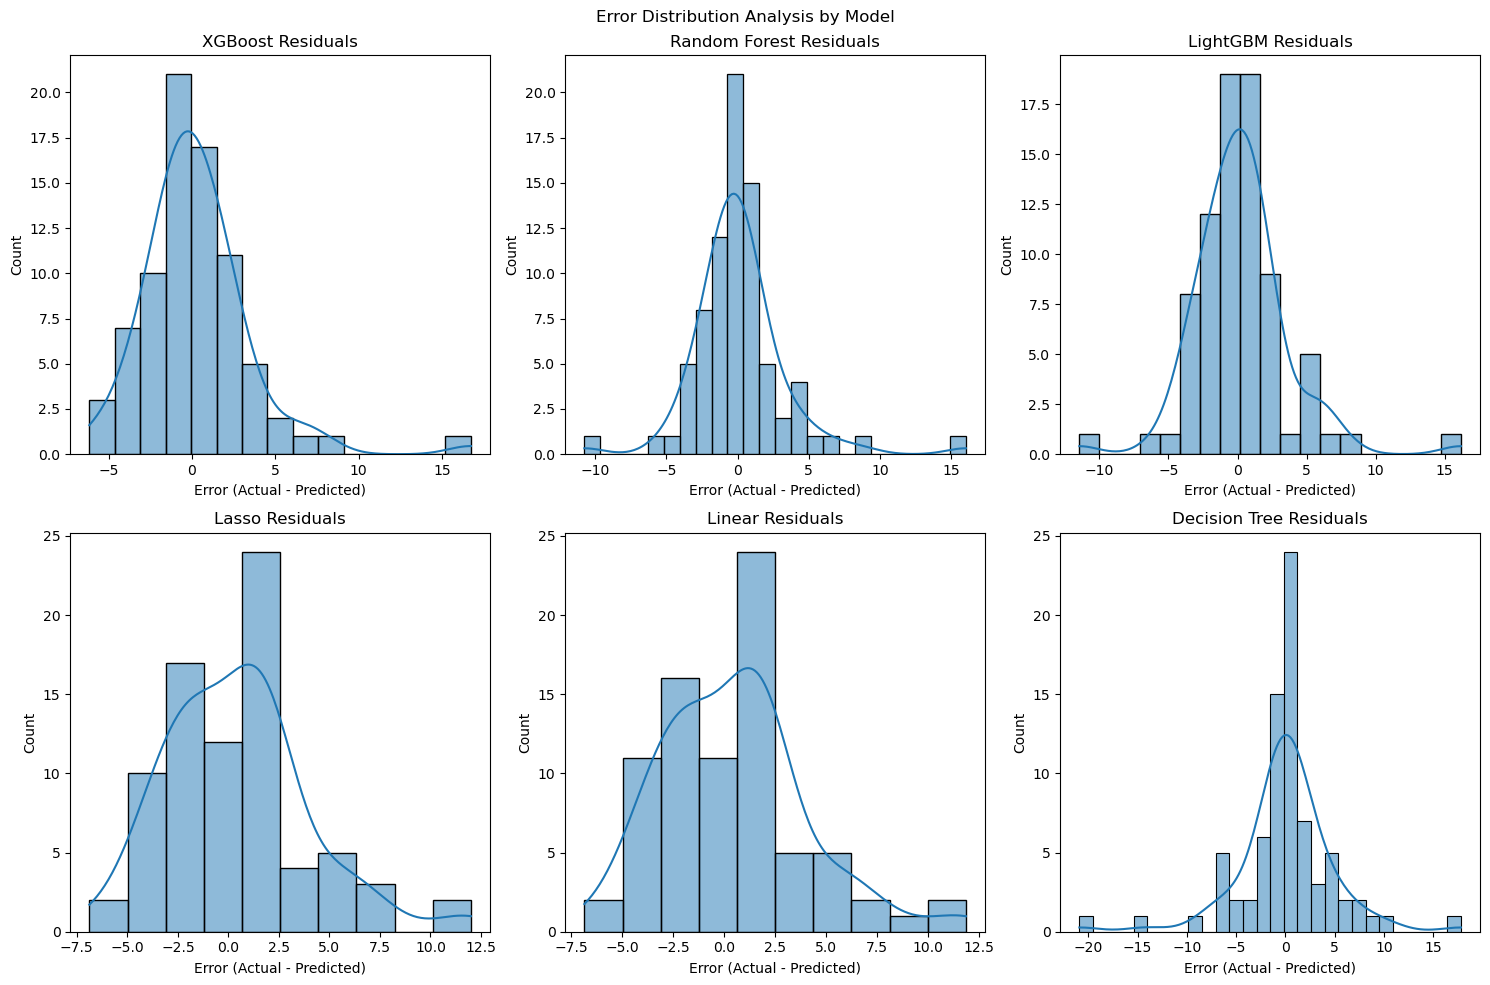

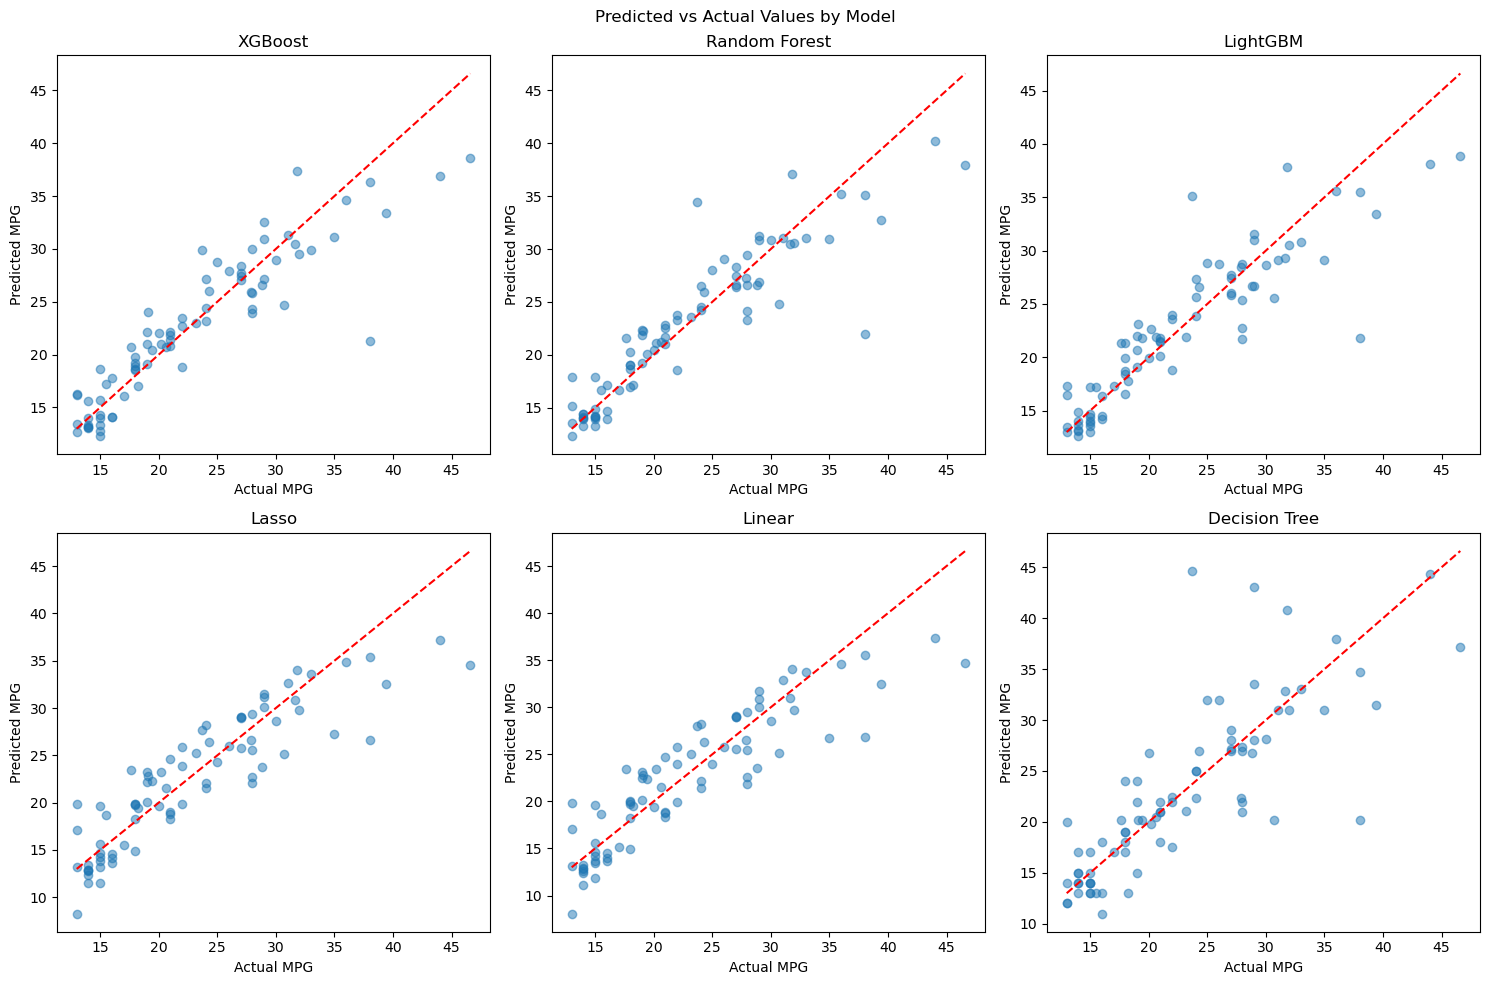

In [48]:
residuals = {
    'XGBoost': y_test - y_test_pred_xgb,
    'Random Forest': y_test - y_test_pred_rf,
    'LightGBM': y_test - y_test_pred_lgb,
    'Lasso': y_test - y_test_pred_lasso,
    'Linear': y_test - y_test_pred_lr,
    'Decision Tree': y_test - y_test_pred_dt
}

# Create subplot figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Error Distribution Analysis by Model')

# Plot histograms of residuals
for (model, res), ax in zip(residuals.items(), axes.flat):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(f'{model} Residuals')
    ax.set_xlabel('Error (Actual - Predicted)')
    ax.set_ylabel('Count')
    
plt.tight_layout()
plt.show()

# Create predicted vs actual plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Predicted vs Actual Values by Model')

for (model, res), ax in zip(residuals.items(), axes.flat):
    pred = y_test - res  # Reconstruct predictions
    ax.scatter(y_test, pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_title(model)
    ax.set_xlabel('Actual MPG')
    ax.set_ylabel('Predicted MPG')
    
plt.tight_layout()
plt.show()

The residual distributions show that:
1. The ensemble models show more symmetric and concentrated error distributions, centered around zero, suggesting more consistent predictions.
2. Linear and Lasso models show slightly right-skewed distributions, indicating they tend to underpredict MPG values.
3. The Decision Tree has the widest error spread and most extreme outliers (-20 to +15 MPG). However, it is the most symmetrical in its errors!

The Predicted vs Actual plots show:
1. All models do well at lower MPG values, which is reflective of the class distribution in the original dataset. Most of the cars in the dataset are in the lower MPG range.
2. All models start under-predicting at higher MPG values. The difference between models is how high MPG can rise before they begin to underpredict. The only exception here is our favorite Decision Tree which is significantly over-predicting. At least DT scores diversity points! 
3. The ensemble models show the tightest clustering around the ideal prediction line (red dashed), especially in the 15-30 MPG range.
4. There appears to be more variance in predictions for mid-range MPG values (25-35 MPG) across all models.

## Findings and interpretation of results

There are several key takeaways from these results:

1. Model Overfitting: Decision Tree shows perfect training performance (R² = 1.0) but the worst test performance (R² = 0.599), indicating severe overfitting. XGBoost and Random Forest also show signs of overfitting with near-perfect training scores but much lower test scores.

2. Best Performers: XGBoost and Random Forest lead in test set performance with R² values of 0.828 and 0.826 respectively. Their RMSE values (around 3.2 MPG) suggest reasonably accurate predictions.

3. Linear Models: The Linear and Lasso Regression models show the most consistent performance between training and test sets, indicating better generalization. Their test R² values (around 0.79) are competitive with the more complex models.

4. Feature Set: With 15 features, the models maintain strong predictive power while keeping reasonable complexity. Both linear and ensemble methods perform well with this feature set.

Based on these results, XGBoost appears to be the best model, but overfitting suggests room for improvement.

## Next Steps

Given more time, I would do the following:

- Gather more data - the small size of this dataset limits how well the model findings can be generalized. I would particularly be looking for more data on fuel efficient cars (i.e. above 30 MPG).
- Experiment with different approaches to handle the non-normality of the predictors & the high correlations between them. These approaches include:
    - Transformations, such as polynomials, interaction terms & Box-Cox Transformations
    - Create more granular car categories
    - Test for time-based features, such as exploring the effect of 1975, the year when the US made catalytic convertors compulsory
    - Investigate outliers and their impact on model performance
- Perform deeper error analysis to find patterns in prediction errors, particularly looking for correlations between predictors and error terms.
- Perform hyperparameter tuning using Cross Validation & regularization on the models.